# HA Bending

In [443]:
from __future__ import print_function
import pyemma
pyemma.__version__
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.weight':'medium', 
         'xtick.major.size':8,
         'ytick.major.size':8}
pylab.rcParams.update(params)
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as pplt
import numpy as np
import pickle 
import mdtraj as md
import itertools

Populating the interactive namespace from numpy and matplotlib


## Load coordinates

In [444]:
#2009 glycosylated HA
indir1 = '/net/gpfs-amarolab/lcasalino/FLU_MSM/pdm2009_H1N1/HA_trajectories/HA_trimers_head_alignment'
top1 =  indir1+'/HA.trimer.pdm.psf'
from glob import glob
trajs1 = glob ('/net/gpfs-amarolab/lcasalino/FLU_MSM/pdm2009_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.*.pdm.head_aligned.dcd')

#2015 glycosylated HA
indir2 = '/net/gpfs-amarolab/lcasalino/FLU_MSM/michigan2015_H1N1/HA_trajectories/HA_trimers_head_alignment'
top2 =  indir2+'/../HA.trimer.michigan.psf'
from glob import glob
trajs2 = glob ('/net/gpfs-amarolab/lcasalino/FLU_MSM/michigan2015_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.*.michigan.head_aligned.dcd')

## Select features and create input data types

#### Head tilt angle
We only need to create the features once, since we are using identical features across all trajectories. Note: VMD's residue selection is equivalent to pyemma/mdtraj's resid selection. First let's create the features that we need.

In [445]:
#feature of minimum distance between COM of heads and middle of stalk
def feature_1(traj: md.Trajectory):
    full1 = np.array([0], dtype=float32) #default is int64 which causes problems when loading coordinates
    full2 = np.array([0], dtype=float32)
    full3 = np.array([0], dtype=float32)
    full4 = np.array([0], dtype=float32)
    centers1 = COM1_H1.transform(traj)  # yields ndarray
    centers2 = COM2_H2.transform(traj)
    centers3 = COM3_H3.transform(traj)
    centers4 = COM_Stalk2.transform(traj)  # yields ndarray
    for i, j in zip(centers1, centers4):
        com1 = np.linalg.norm(np.subtract(i,j))
        full1 = np.append(full1, com1)
    reshaped1 = np.reshape(full1, (-1, 1))
    reshaped1 = reshaped1[1:]
    reshaped1 = reshaped1.astype('float32')
    for i, j in zip(centers2, centers4):
        com2 = np.linalg.norm(np.subtract(i,j))
        full2 = np.append(full2, com2)
    reshaped2 = np.reshape(full2, (-1, 1))
    reshaped2 = reshaped2[1:]
    reshaped2 = reshaped2.astype('float32')
    for i, j in zip(centers3, centers4):
        com3 = np.linalg.norm(np.subtract(i,j))
        full3 = np.append(full3, com3)
    reshaped3 = np.reshape(full3, (-1, 1))
    reshaped3 = reshaped3[1:]
    reshaped3 = reshaped3.astype('float32')
    minimum1 = np.hstack((reshaped1, reshaped2, reshaped3))
    minimum2 = np.min(minimum1, axis=1)
    minimum3 = np.asarray(minimum2)
    minimum4 = np.reshape(minimum3, (-1, 1))
    minimum4 = minimum4.astype('float32')
    return minimum4


#feature of minimum distance between COM of head tips and bottom of stalk
def feature_2(traj: md.Trajectory):
    full1 = np.array([0], dtype=float32) #default is int64 which causes problems when loading coordinates
    full2 = np.array([0], dtype=float32)
    full3 = np.array([0], dtype=float32)
    full4 = np.array([0], dtype=float32)
    centers1 = Tip1.transform(traj)  # yields ndarray
    centers2 = Tip2.transform(traj)
    centers3 = Tip3.transform(traj)
    centers4 = COM_Stalk.transform(traj)  # yields ndarray
    for i, j in zip(centers1, centers4):
        com1 = np.linalg.norm(np.subtract(i,j))
        full1 = np.append(full1, com1)
    reshaped1 = np.reshape(full1, (-1, 1))
    reshaped1 = reshaped1[1:]
    reshaped1 = reshaped1.astype('float32')
    for i, j in zip(centers2, centers4):
        com2 = np.linalg.norm(np.subtract(i,j))
        full2 = np.append(full2, com2)
    reshaped2 = np.reshape(full2, (-1, 1))
    reshaped2 = reshaped2[1:]
    reshaped2 = reshaped2.astype('float32')
    for i, j in zip(centers3, centers4):
        com3 = np.linalg.norm(np.subtract(i,j))
        full3 = np.append(full3, com3)
    reshaped3 = np.reshape(full3, (-1, 1))
    reshaped3 = reshaped3[1:]
    reshaped3 = reshaped3.astype('float32')
    minimum1 = np.hstack((reshaped1, reshaped2, reshaped3))
    minimum2 = np.min(minimum1, axis=1)
    minimum3 = np.asarray(minimum2)
    minimum4 = np.reshape(minimum3, (-1, 1))
    minimum4 = minimum4.astype('float32')
    return minimum4

In [446]:
feat_bending_2009g = pyemma.coordinates.featurizer(top1)

COM1 = feat_bending_2009g.topology.select('resid 50 to 150 and name CA')
COM2 = feat_bending_2009g.topology.select('resid 630 to 860 and name CA')
COM3 = feat_bending_2009g.topology.select('resid 1220 to 1410 and name CA')
tip1 = feat_bending_2009g.topology.select('resid 176')
tip2 = feat_bending_2009g.topology.select('resid 739')
tip3 = feat_bending_2009g.topology.select('resid 1305')
COM_Stalk1 = feat_bending_2009g.topology.select('resid 547 1113 1679 and name CA')
COM_Stalk2 = feat_bending_2009g.topology.select('resid 350 1022 1478 and name CA')

from pyemma.coordinates.data.featurization.misc import GroupCOMFeature

COM1_H1 = GroupCOMFeature(feat_bending_2009g.topology, [COM1])
COM2_H2 = GroupCOMFeature(feat_bending_2009g.topology, [COM2])
COM3_H3 = GroupCOMFeature(feat_bending_2009g.topology, [COM3])
Tip1 = GroupCOMFeature(feat_bending_2009g.topology, [tip1])
Tip2 = GroupCOMFeature(feat_bending_2009g.topology, [tip2])
Tip3 = GroupCOMFeature(feat_bending_2009g.topology, [tip3])
COM_Stalk = GroupCOMFeature(feat_bending_2009g.topology, [COM_Stalk1])
COM_Stalk2 = GroupCOMFeature(feat_bending_2009g.topology, [COM_Stalk2])

feat_bending_2009g.add_custom_func(feature_1, dim=1, description='bending')
feat_bending_2009g.add_custom_func(feature_2, dim=1, description='bending')
print(feat_bending_2009g.dimension())
print(feat_bending_2009g.describe())

2
['bending', 'bending']


In [447]:
feat_bending_2015g = pyemma.coordinates.featurizer(top2)

#these sorta work, but trying different features to see if others work better
COM1 = feat_bending_2015g.topology.select('resid 50 to 150 and name CA')
COM2 = feat_bending_2015g.topology.select('resid 630 to 860 and name CA')
COM3 = feat_bending_2015g.topology.select('resid 1220 to 1410 and name CA')
tip1 = feat_bending_2015g.topology.select('resid 176')
tip2 = feat_bending_2015g.topology.select('resid 739')
tip3 = feat_bending_2015g.topology.select('resid 1305')
COM_Stalk1 = feat_bending_2015g.topology.select('resid 547 1113 1679 and name CA')
COM_Stalk2 = feat_bending_2015g.topology.select('resid 350 1022 1478 and name CA')

from pyemma.coordinates.data.featurization.misc import GroupCOMFeature

COM1_H1 = GroupCOMFeature(feat_bending_2015g.topology, [COM1])
COM2_H2 = GroupCOMFeature(feat_bending_2015g.topology, [COM2])
COM3_H3 = GroupCOMFeature(feat_bending_2015g.topology, [COM3])
Tip1 = GroupCOMFeature(feat_bending_2015g.topology, [tip1])
Tip2 = GroupCOMFeature(feat_bending_2015g.topology, [tip2])
Tip3 = GroupCOMFeature(feat_bending_2015g.topology, [tip3])
COM_Stalk = GroupCOMFeature(feat_bending_2015g.topology, [COM_Stalk1])
COM_Stalk2 = GroupCOMFeature(feat_bending_2015g.topology, [COM_Stalk2])

feat_bending_2015g.add_custom_func(feature_1, dim=1, description='bending')
feat_bending_2015g.add_custom_func(feature_2, dim=1, description='bending')
print(feat_bending_2015g.dimension())
print(feat_bending_2015g.describe())

2
['bending', 'bending']


We will also print some info about the data we loaded to make sure we are loading the correct trajectories. The shape of the first element should show the number of frames it has and the number of features we selected. This can take 30 minutes.

In [448]:
#lag time here doesn't really matter
print("2009 glycosylated HA")
data_2009_glycosylated = pyemma.coordinates.load(trajs1, features=feat_bending_2009g)
print('trajectory time step = .06 ns')
print("data_2009_glycosylated has",len(data_2009_glycosylated), "trajectories")
print("data_2009_glycosylated has",(data_2009_glycosylated[0].shape[0]), "frames in the first trajectory")
print("data_2009_glycosylated has",(data_2009_glycosylated[0].shape[1]), "features")

print("2015 glycosylated HA")
data_2015_glycosylated = pyemma.coordinates.load(trajs2, features=feat_bending_2015g)
print('trajectory time step = .06 ns')
print("data_2015_glycosylated has",len(data_2015_glycosylated), "trajectories")
print("data_2015_glycosylated has",(data_2015_glycosylated[0].shape[0]), "frames in the first trajectory")
print("data_2015_glycosylated has",(data_2015_glycosylated[0].shape[1]), "features")

2009 glycosylated HA


trajectory time step = .06 ns
data_2009_glycosylated has 236 trajectories
data_2009_glycosylated has 7363 frames in the first trajectory
data_2009_glycosylated has 2 features
2015 glycosylated HA


trajectory time step = .06 ns
data_2015_glycosylated has 236 trajectories
data_2015_glycosylated has 7083 frames in the first trajectory
data_2015_glycosylated has 2 features


Let's save the data types created so we can load them later (and then load them for use)

In [449]:
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/data_2009_glycosylated.txt', 'wb') as fp:
    pickle.dump(data_2009_glycosylated, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/data_2009_glycosylated.txt', 'rb') as fp:
    data_2009_glycosylated = pickle.load(fp)
    
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/data_2015_glycosylated.txt', 'wb') as fp:
    pickle.dump(data_2015_glycosylated, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/data_2015_glycosylated.txt', 'rb') as fp:
    data_2015_glycosylated = pickle.load(fp)

# TICA and clustering

Let's create the TICA object from our original data. Note, this TICA lag time must be shorter than or equal to the MSM lag time. Additionally, our simulations must be longer than 500 steps for this MSM to be valid, which they are. If the lag time (time step) was longer than the simulation time, that would mean we could not resolve any motions at all. The timestep conversion used for in making these trajectories is 0.06 ns. Thus we have 500 * 0.06 = 40 ns; these trajectories are ~450 ns so they pass the test.

In [450]:
print("2009 glycosylated dataset")
tica_obj_2009g = coor.tica(data_2009_glycosylated, lag=25, kinetic_map=False, var_cutoff=0.95, reversible=True) #lag time in steps (.02ns/step)
print(tica_obj_2009g.describe())
print("2015 glycosylated dataset")
tica_obj_2015g = coor.tica(data_2015_glycosylated, lag=25, kinetic_map=False, var_cutoff=0.95, reversible=True) #lag time in steps (.02ns/step)
print(tica_obj_2015g.describe())

2009 glycosylated dataset


[TICA, lag = 25; max. output dim. = 2]
2015 glycosylated dataset


[TICA, lag = 25; max. output dim. = 2]


These functions will (1) map the input data of the transformer and return it as a list of arrays, and (2) concatenate that list into a numpy array

In [451]:
tica_output_2009g = tica_obj_2009g.get_output()
tica_concatenated_2009g = np.concatenate(tica_output_2009g)
tica_output_2015g = tica_obj_2015g.get_output()
tica_concatenated_2015g = np.concatenate(tica_output_2015g)

The concatenated datasets below are a tuple. What is the first list and what is the second list? The first list is the number of frames in the dataset, and the second is the tICs - we show each of these in two ways below for validation.

In [452]:
print("The 2009 unglycosylated dataset has",(tica_obj_2009g.n_frames_total()),"frames")
print("The 2009 unglycosylated dataset has",(tica_concatenated_2009g.shape[0]),"frames")
print("The 2009 unglycosylated dataset has",(tica_obj_2009g.dimension()),"dimensions")
print("The 2009 unglycosylated dataset has",(tica_concatenated_2009g.shape[1]),"dimensions")

The 2009 unglycosylated dataset has 1737668 frames
The 2009 unglycosylated dataset has 1737668 frames
The 2009 unglycosylated dataset has 2 dimensions
The 2009 unglycosylated dataset has 2 dimensions


Now we can describe the tuple that is our concatenated output datasets, remembering that TICA dimensions are the TICA internal coordinates.

In [453]:
print("The 2009 glycosylated dataset has",(tica_concatenated_2009g.shape[0]),"frames and",(tica_concatenated_2009g.shape[1]),"tICs")
print("The 2015 glycosylated dataset has",(tica_concatenated_2015g.shape[0]),"frames and",(tica_concatenated_2015g.shape[1]),"tICs")

The 2009 glycosylated dataset has 1737668 frames and 2 tICs
The 2015 glycosylated dataset has 1671588 frames and 2 tICs


The next step is to use this reduced-dimensions data to cluster our data, and create the discrete trajectories (dtrajs) as a function of the k-means cluster centers. You can see how the data is spread over the energy landscape in the graph below, where we are plotting the free energy landscape with the cluster centers (in black); this can take maybe 15 minutes to run. We select 300 clusters (k=300) and 32 processors to run (n_jobs=32)

In [454]:
#2009 glycosylated
clk_2009g = coor.cluster_kmeans(tica_output_2009g, k=300, max_iter=70, n_jobs=32, fixed_seed=True)
dtrajs_2009g = clk_2009g.dtrajs

#2015 glycosylated
clk_2015g = coor.cluster_kmeans(tica_output_2015g, k=300, max_iter=70, n_jobs=32, fixed_seed=True)
dtrajs_2015g = clk_2015g.dtrajs

With the discrete trajectories created, let's save and then load them:

In [455]:
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/clk_2009g.txt', 'wb') as fp:
    pickle.dump(clk_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/dtrajs_2009g.txt', 'wb') as fp:
    pickle.dump(dtrajs_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/clk_2015g.txt', 'wb') as fp:
    pickle.dump(clk_2015g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/dtrajs_2015g.txt', 'wb') as fp:
    pickle.dump(dtrajs_2015g, fp)
    
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/clk_2009g.txt', 'rb') as fp:
    clk_2009g = pickle.load(fp) 
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/dtrajs_2009g.txt', 'rb') as fp:
    dtrajs_2009g = pickle.load(fp) 
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/clk_2015g.txt', 'rb') as fp:
    clk_2015g = pickle.load(fp) 
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/dtrajs_2015g.txt', 'rb') as fp:
    dtrajs_2015g = pickle.load(fp) 

## MSM creation 

Let's look at the implied timescales for the MSM. Here we are selecting six macrostates with a lag time of 10000 steps. This took maybe 10 minutes. After seeing the timescale separation plot, I redid this step, changing around the number of states selected.

<Figure size 1080x1080 with 0 Axes>

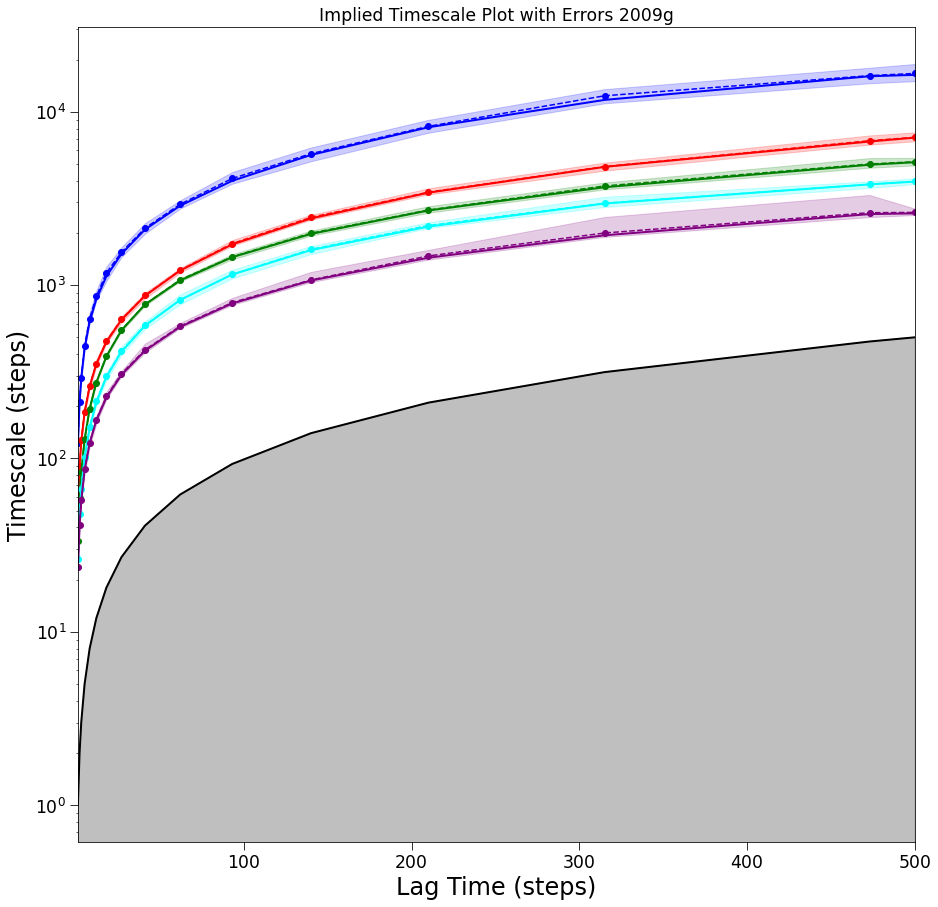

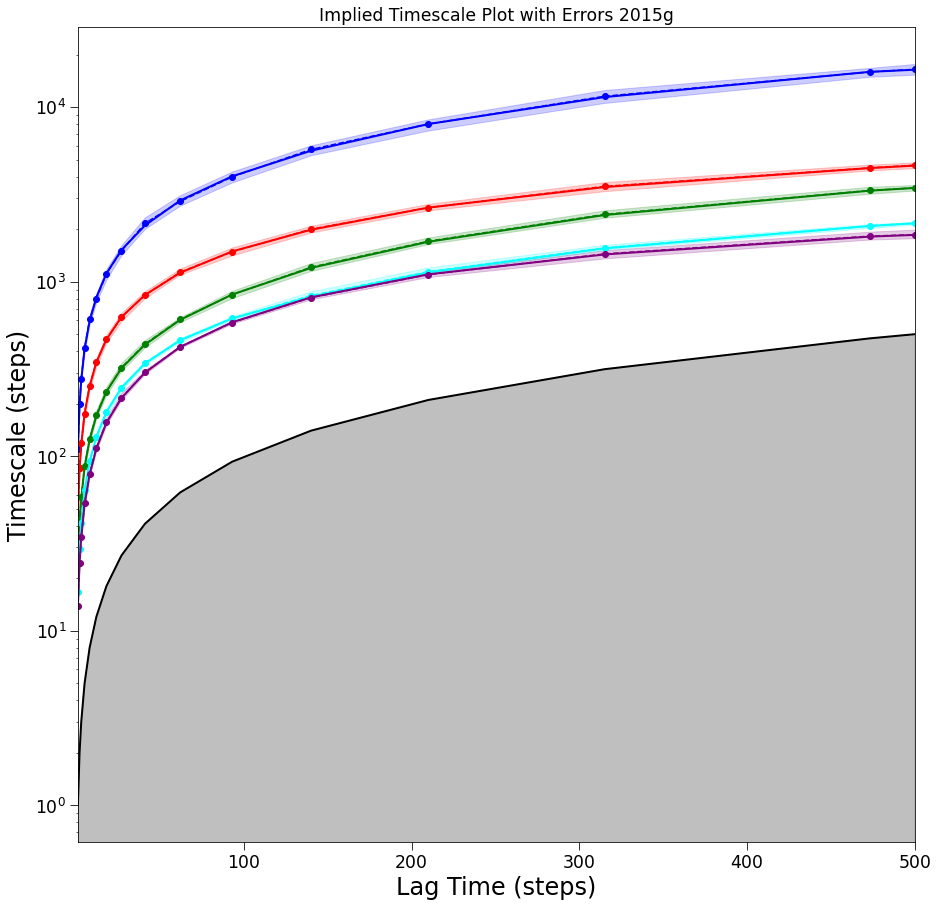

<Figure size 1080x1080 with 0 Axes>

In [456]:
#2009 glycosylated
its = msm.timescales_msm(dtrajs_2009g, lags=500, nits=5, n_jobs=32, errors='bayes') #errors='bayes'
pplt.plot_implied_timescales(its, units='steps', nits=5, linewidth=2) #units can be ns if desired
plt.title('Implied Timescale Plot with Errors 2009g')
plt.xlabel('Lag Time (steps)', fontsize=24)
plt.ylabel('Timescale (steps)', fontsize=24)
plt.savefig('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/figures/its_msm_2009g.png', dpi=300)
plt.figure()

#2015 glycosylated
its = msm.timescales_msm(dtrajs_2015g, lags=500, nits=5, n_jobs=32, errors='bayes') #errors='bayes'
pplt.plot_implied_timescales(its, units='steps', nits=5, linewidth=2) #units can be ns if desired
plt.title('Implied Timescale Plot with Errors 2015g')
plt.xlabel('Lag Time (steps)', fontsize=24)
plt.ylabel('Timescale (steps)', fontsize=24)
plt.savefig('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/figures/its_msm_2015g.png', dpi=300)
plt.figure()

It's important that the lag time used in the cell below (the MSM lag time) is equal to or larger than the TICA lag time (seen in the coor.tica cell much earlier - we selected a TICA lag time of 500 steps). TICA can only resolve motions longer than its lag time, because a motion shorter than the lag time is simply not seen. This is why it only makes sense to choose an MSM lag time that is equal to or larger than the TICA lag time. From all this, we will select an MSM lag time of 500 steps, which is roughly at the start of where the lines flatten out. Now let's go ahead and create an MSM at the lag time we selected.

In [457]:
msm_2009g = msm.bayesian_markov_model(dtrajs_2009g, 50, reversible=True)
msm_2015g = msm.bayesian_markov_model(dtrajs_2015g, 50, reversible=True)

Now let's save the MSM data and reload it:

In [458]:
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2009g.txt', 'wb') as fp:
    pickle.dump(msm_2009g, fp)
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2009g.txt', 'rb') as fp:
    msm_2009g = pickle.load(fp) 
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2015g.txt', 'wb') as fp:
    pickle.dump(msm_2015g, fp)
with open ('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2015g.txt', 'rb') as fp:
    msm_2015g = pickle.load(fp) 

Each dot on this plot shows the timescale separation between one metastable state and the following metastable state. Thus the first dot shows the timescale separation between the first metastable state and the second metastable state, which corresponds to one slow motion. We want to pick all of the dots that are separated from each other, which is a qualitative task. If your selections don't generate interesting slow motions you can select more, but the dots with low separation (~1) represent the overlapping lines on the implied timescale plot, so they likely represent the same motion.

<Figure size 1080x1080 with 0 Axes>

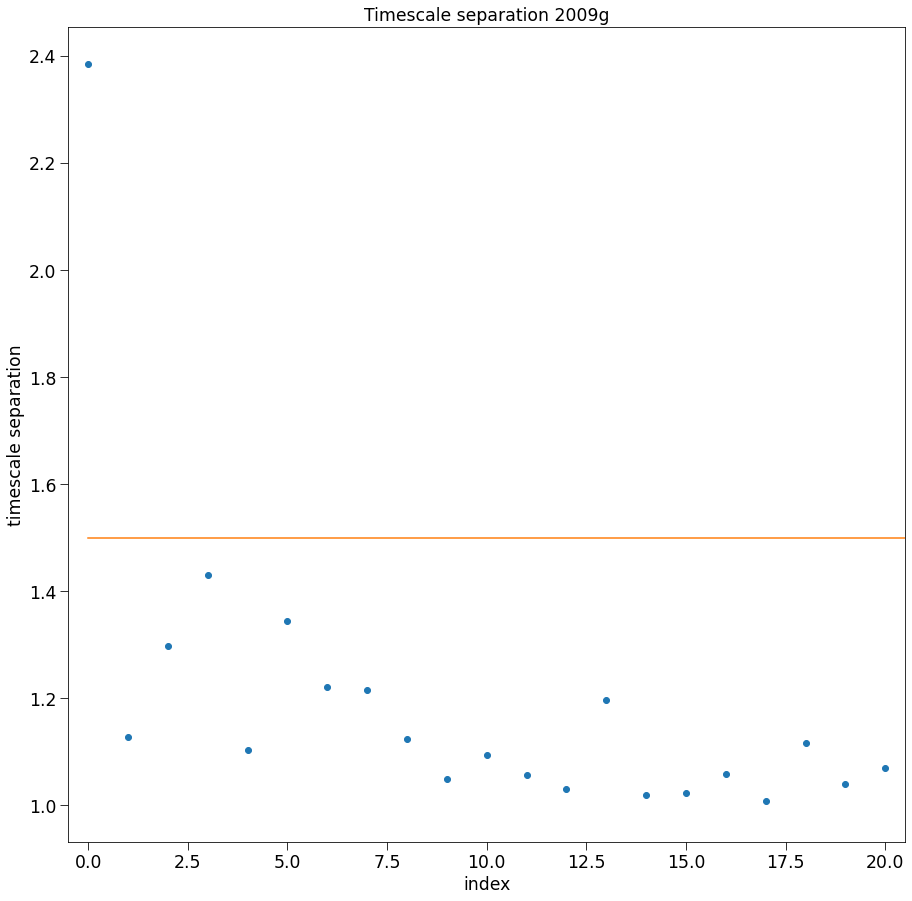

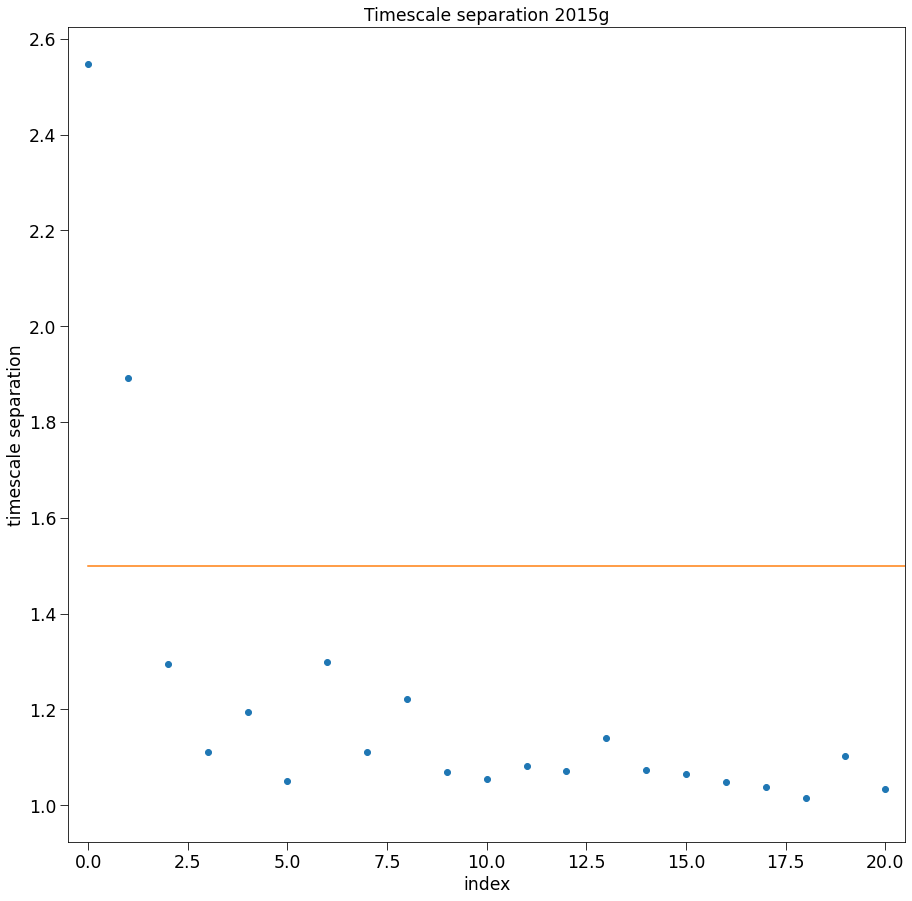

<Figure size 1080x1080 with 0 Axes>

In [459]:
#2009 glycosylated
plot(msm_2009g.timescales()[:-1]/msm_2009g.timescales()[1:], linewidth=0,marker='o')
plot(np.full(len(msm_2009g.timescales()[:-1]/msm_2009g.timescales()[1:]), 1.5))
plt.title('Timescale separation 2009g')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,20.5)
plt.figure()

#2015 glycosylated
plot(msm_2015g.timescales()[:-1]/msm_2015g.timescales()[1:], linewidth=0,marker='o')
plot(np.full(len(msm_2015g.timescales()[:-1]/msm_2015g.timescales()[1:]), 1.5))
plt.title('Timescale separation 2015g')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,20.5)
plt.figure()

For the 2009 dataset, dot with index 3 (the 4rd dot overall) is the last dot with a decent timescale separation (>1.5), so we would normally choose 4 dots on our first try. From iterating we know that we need to choose 1 dot to see our interesting slow motion. Choosing 4 dots means that we are choosing 6 metastable states, which correspond to 5 slow motions. This is a qualitative method to estimate how many states you should choose. A better method would be to examine the stationary distribution, which we will do later.

Now let's run the CK test on the six macrostates that we chose above This test estimates if you would still predict the same transition given an infinite lag time. We will run with 32 processors. Note: the mlags tells how long of a lag time to calculate. If the implied timescale plot shows the lines running into the forbidden region after lag time of 5, you would not want to choose an mlags greater than 5 here.

If you get an error that says "index 297 is out of bounds for axis 0 with size 297" that means you need to select a smaller lag

CPU times: user 25.5 s, sys: 29.1 s, total: 54.6 s
Wall time: 1min 36s


CPU times: user 28.2 s, sys: 25.2 s, total: 53.4 s
Wall time: 1min 49s


<Figure size 1080x1080 with 0 Axes>

<Figure size 3600x2700 with 0 Axes>

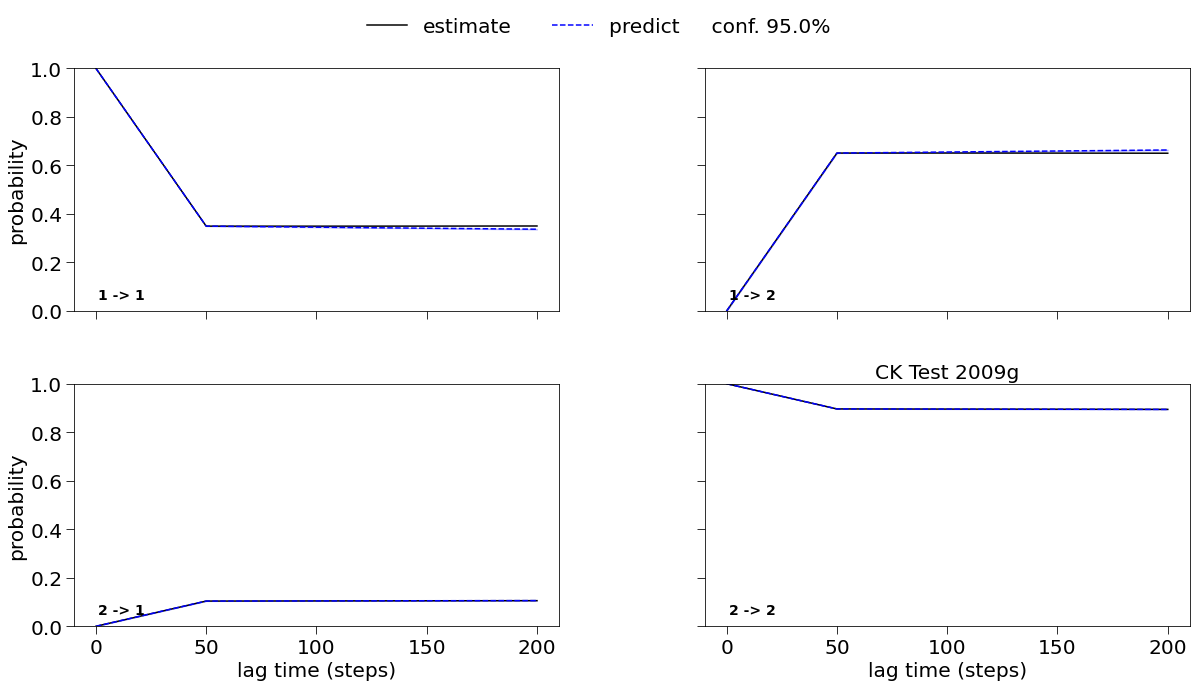

<Figure size 1080x1080 with 0 Axes>

<Figure size 3600x2700 with 0 Axes>

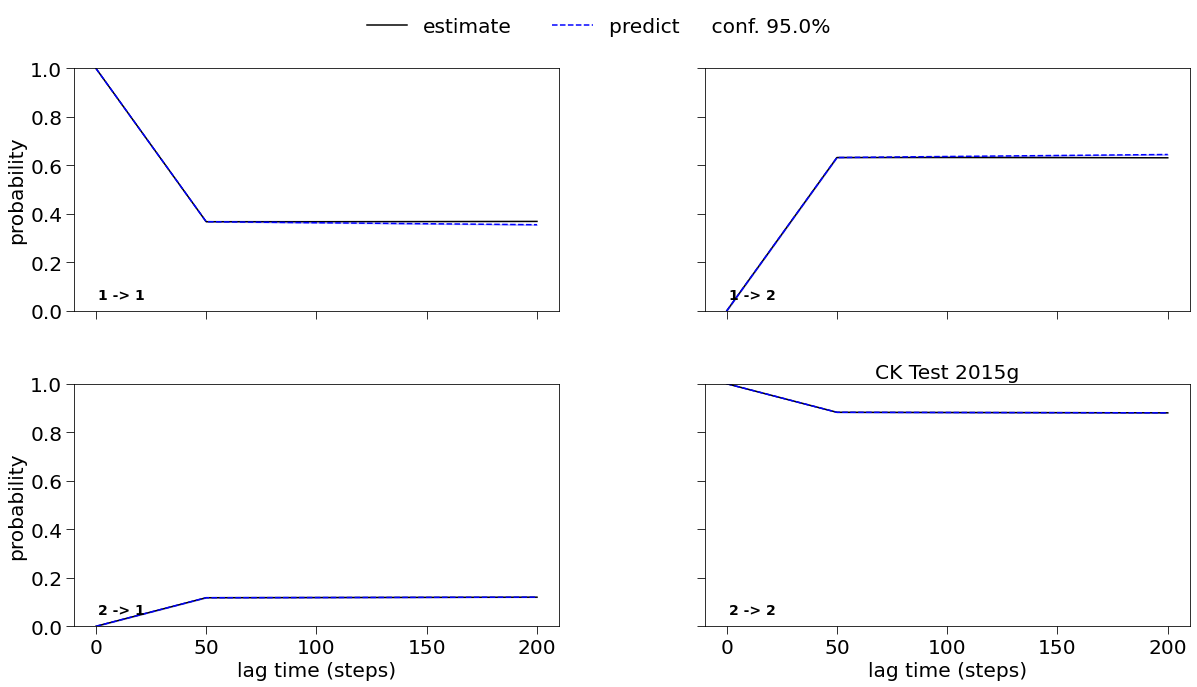

<Figure size 1080x1080 with 0 Axes>

In [460]:
#2009 glycosylated
%time ck_2009g = msm_2009g.cktest(2, memberships=None, mlags=5, conf=0.95, err_est=False, n_jobs=32, show_progress=True)
plt.figure(figsize=(12,9), dpi=300)
matplotlib.rcParams.update({'font.size': 14})
pplt.plot_cktest(ck_2009g, diag=False, figsize=(20,10), layout=(4,4), padding_top=0.1, y01=True, padding_between=0.3, dt=1.0, units='steps')
plt.title('CK Test 2009g')
plt.savefig('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/figures/ck_msm_2009g.png')
plt.figure()

#2015 glycosylated
%time ck_2015g = msm_2015g.cktest(2, memberships=None, mlags=5, conf=0.95, err_est=False, n_jobs=32, show_progress=True)
plt.figure(figsize=(12,9), dpi=300)
matplotlib.rcParams.update({'font.size': 14})
pplt.plot_cktest(ck_2015g, diag=False, figsize=(20,10), layout=(4,4), padding_top=0.1, y01=True, padding_between=0.3, dt=1.0, units='steps')
plt.title('CK Test 2015g')
plt.savefig('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/figures/ck_msm_2015g.png')
plt.figure()

We are now calculating the stationary distribution of the two macrostates that we selected earlier. Normally we would want each valid macrostate to have a population of above maybe 5-10% of all states, and we would iterate over the number of states selected until we find all the ones with a population above 5-10%. We find this here.

In [461]:
#2009 glycosylated
nstates = 2
print("The 2009 glycosylated stationary distribution is:")
msm_2009g.pcca(nstates)
for i, s in enumerate(msm_2009g.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm_2009g.pi[s].sum()))

#2015 glycosylated
nstates = 2
print("The 2015 glycosylated stationary distribution is:")
msm_2015g.pcca(nstates)
for i, s in enumerate(msm_2015g.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, msm_2015g.pi[s].sum()))

The 2009 glycosylated stationary distribution is:
π_1 = 0.063107
π_2 = 0.936893
The 2015 glycosylated stationary distribution is:
π_1 = 0.062153
π_2 = 0.937847


For 2009 and 2015, state 1 is tilted and state 2 is untilted.

In [462]:
#### nstates = 2
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm_2009g.mfpt(
            msm_2009g.metastable_sets[i],
            msm_2009g.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
display(DataFrame(np.round(mfpt, decimals=2), index=range(0, nstates), columns=range(0, nstates)).multiply(0.06))


nstates = 2
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm_2015g.mfpt(
            msm_2015g.metastable_sets[i],
            msm_2015g.metastable_sets[j])

from pandas import DataFrame
print('MFPT / ns:')
display(DataFrame(np.round(mfpt, decimals=2), index=range(0, nstates), columns=range(0, nstates)).multiply(0.06))

MFPT / ns:


0        1
0     0.0000  63.0144
1  1324.9608   0.0000

MFPT / ns:


0        1
0     0.0000  67.8828
1  1185.1902   0.0000

The matrix above contain MFPTs between all transitions that originate in a "line" state and end in a "column" state. That means that you select the state on the left, and see which state it falls under. That is the mean first passage time from the row state to the column state. 

With our MSM constructed, we now want to select some structures from that MSM for visualization. How do we do that? By constructing our MSM, we are doing a form of clustering to put all the microstates into a small number of macrostates; for our model we chose two macrostates for each dataset. However, it is quite important to realize that assigning microstates to MSM macrostates is a "fuzzy" process, in the sense that each microstate receives a probability of being assigned to each macrostates - it is not a one-to-one assignment that one would intuitively think of. Some of these assignments are done with high confidence, meaning the microstate has a high probability of being assigned to a specific macrostate, and some are done woth lower confidence, meaning that the microstate doesn't have a particularly high probability of being assigned to any macrostate. Our probabilities fall on a continuum, so there isn't a clearly defined set of good, high probability structures. We will need to make this set ourselves, by defining a probabiliyt cutoff. We will do that in this section, and then visualize those high probability structures. If you need to, reload the data from the cell above before proceeding.

Here, we need to select microstates from our previously created macrostates. We select a membership cutoff, but we can change this if needed to make sure that we actually select some microstates - if we set the cutoff too high then no microstates will satisfy the cutoff and thus none will be created. However, we want it high to select structures that are representative of that macrostate and don't have assignments in other macrostates. For the clusters that pass the membership cutoff, we will randomly select frames from those clusters. Note, here we are creating pdb trajectories. These are very memory-inefficient, it would be much preferable to create GROMACS xtc trajectories and then create a single coordinatee gro file, or at least create dcd trajectories to go along with our pdb file. However, these other options did not produce a consistently visible output in visualization programs (likely because the coordinates were not aligned to the same space, and were still in the original space from when they were extracted from the virion, i.e. assembled in a sphere), leaving us with no choice but to use pdb trajectories.

In [463]:
#2009 glycosylated
inp_2009g = coor.source(trajs1, features=feat_bending_2009g)
macrostates = 2

for N in range(0,macrostates):
    microstates = []
    
    ## Microstates belonging to macrostates N
    for i in msm_2009g.metastable_sets[N]:
        microstates.append(i)
    print('MACROSTATE ' +str(N))
    
    ## Check membership probability and select only clusters with membership above cutoff
    
    representative_microstates = []
    for cl in microstates:
        if msm_2009g.metastable_memberships[cl][N] > 0.99999999:   ## Specify the state membership cutoff you would like
            print('microstate = '+str(cl))
            print(msm_2009g.metastable_memberships[cl,:]) # Obtain metastable membership of microstate N
            print(msm_2009g.metastable_assignments[cl]) #Obtain macrostate assignment of microstate N
            print(str(len(clk_2009g.index_clusters[cl]))+'\n')  #Obtain number of frames in microstate N
            representative_microstates.append(cl)       
            
    #Pulling 10 representative frames from selected microstate cl
    for cl in representative_microstates:
        microstate_samples = msm_2009g.sample_by_state(10)
        # Give directory path of where structures should be saved
        coor.save_traj(inp_2009g, microstate_samples[cl], '/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/2009g_macrostate'+str(N)+'_microstate'+str(cl)+'.pdb')
        print(microstate_samples[cl])
        
                
#2015 glycosylated
inp_2015g = coor.source(trajs2, features=feat_bending_2015g)
macrostates = 2

for N in range(0,macrostates):
    microstates = []
    
    ## Microstates belonging to macrostates N
    for i in msm_2015g.metastable_sets[N]:
        microstates.append(i)
    print('MACROSTATE ' +str(N))
    
    ## Check membership probability and select only clusters with membership above cutoff
    
    representative_microstates = []
    for cl in microstates:
        if msm_2015g.metastable_memberships[cl][N] > 0.99999999:   ## Specify the state membership cutoff you would like
            print('microstate = '+str(cl))
            print(msm_2015g.metastable_memberships[cl,:]) # Obtain metastable membership of microstate N
            print(msm_2015g.metastable_assignments[cl]) #Obtain macrostate assignment of microstate N
            print(str(len(clk_2015g.index_clusters[cl]))+'\n')  #Obtain number of frames in microstate N
            representative_microstates.append(cl)       
            
    #Pulling 10 representative frames from selected microstate cl
    for cl in representative_microstates:
        microstate_samples = msm_2015g.sample_by_state(10)
        # Give directory path of where structures should be saved
        coor.save_traj(inp_2015g, microstate_samples[cl], '/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/2015g_macrostate'+str(N)+'_microstate'+str(cl)+'.pdb')
        print(microstate_samples[cl])

MACROSTATE 0
microstate = 171
[1.00000000e+00 9.39479881e-14]
0
670

16-03-22 14:03:27 pyemma.coordinates.api INFO     Created file /net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/2009g_macrostate0_microstate171.pdb
[[ 163 6980]
 [ 163 6813]
 [ 163 7107]
 [ 163 7048]
 [ 163 6830]
 [ 163 7091]
 [ 163 6624]
 [ 163 6938]
 [ 163 5493]
 [ 163 7334]]
MACROSTATE 1
microstate = 59
[0. 1.]
1
923

16-03-22 14:03:29 pyemma.coordinates.api INFO     Created file /net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/2009g_macrostate1_microstate59.pdb
[[ 155 1456]
 [ 155 1210]
 [ 155  285]
 [ 155  288]
 [ 155 1179]
 [ 155 3272]
 [ 155  408]
 [ 155 2102]
 [ 155 1632]
 [ 155  560]]


MACROSTATE 0
microstate = 203
[1. 0.]
0
791

16-03-22 14:03:39 pyemma.coordinates.api INFO     Created file /net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/2015g_macrostate0_microstate203.pdb
[[  39 5470]
 [  39 2153]
 [  39 6991]
 [  39 5233]
 [  39 5181]
 [  39 7019]
 [  39 2175]
 [  39 7056]
 [  39 6634]
 [  39 6928]]
MACROSTATE 1
microstate = 255
[1.51655252e-15 1.00000000e+00]
1
1720

16-03-22 14:03:41 pyemma.coordinates.api INFO     Created file /net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/2015g_macrostate1_microstate255.pdb
[[  26 2152]
 [ 134 4102]
 [ 134 3991]
 [ 134 2574]
 [ 134 3327]
 [  69 5145]
 [ 132 1573]
 [  77 5252]
 [ 134 3475]
 [ 134 4439]]


In [464]:
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2009g.txt', 'wb') as fp:
    pickle.dump(msm_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/kmeans_clustering_2009g.pyemma', 'wb') as fp:
    pickle.dump(clk_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2009g.pyemma', 'wb') as fp:
    pickle.dump(dtrajs_2009g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2015g.txt', 'wb') as fp:
    pickle.dump(msm_2015g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/kmeans_clustering_2015g.pyemma', 'wb') as fp:
    pickle.dump(clk_2015g, fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2015g.pyemma', 'wb') as fp:
    pickle.dump(dtrajs_2015g, fp) 

with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2009g.txt', 'rb') as fp:
    msm_2009g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/kmeans_clustering_2009g.pyemma', 'rb') as fp:
    clk_2009g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2009g.pyemma', 'rb') as fp:
    dtrajs_2009g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2015g.txt', 'rb') as fp:
    msm_2015g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/kmeans_clustering_2015g.pyemma', 'rb') as fp:
    clk_2015g = pickle.load(fp)
with open('/net/gpfs-amarolab/cseitz/from_jam/projects/influenza/hemagglutinin/msm/bending/files/msm_2015g.pyemma', 'rb') as fp:
    dtrajs_2015g = pickle.load(fp)

Which trajectories were these microstates sampled from? We can check this out.

In [473]:
print("The 2009 macrostate 0 comes from the",(trajs1[163]), "trajectory file")
print("The 2009 macrostate 1 comes from the",(trajs1[155]), "trajectory file")
print("The 2015 macrostate 0 comes from the",(trajs2[39]), "trajectory file")
print("The 2015 macrostate 1 comes from the",(trajs2[26]), "trajectory file")
print("The 2015 macrostate 1 comes from the",(trajs2[134]), "trajectory file")
print("The 2015 macrostate 1 comes from the",(trajs2[69]), "trajectory file")
print("The 2015 macrostate 1 comes from the",(trajs2[132]), "trajectory file")
print("The 2015 macrostate 1 comes from the",(trajs2[77]), "trajectory file")

The 2009 macrostate 0 comes from the /net/gpfs-amarolab/lcasalino/FLU_MSM/pdm2009_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.186.pdm.head_aligned.dcd trajectory file
The 2009 macrostate 1 comes from the /net/gpfs-amarolab/lcasalino/FLU_MSM/pdm2009_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.164.pdm.head_aligned.dcd trajectory file
The 2015 macrostate 0 comes from the /net/gpfs-amarolab/lcasalino/FLU_MSM/michigan2015_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.181.michigan.head_aligned.dcd trajectory file
The 2015 macrostate 1 comes from the /net/gpfs-amarolab/lcasalino/FLU_MSM/michigan2015_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.107.michigan.head_aligned.dcd trajectory file
The 2015 macrostate 1 comes from the /net/gpfs-amarolab/lcasalino/FLU_MSM/michigan2015_H1N1/HA_trajectories/HA_trimers_head_alignment/HA.trimer.6.michigan.head_aligned.dcd trajectory file
The 2015 macrostate 1 comes from the /net/gpfs-amarolab/lcasalino/FLU_MS